# Deep Learning challenge

## Authors

Lukáš Varga

Francesco Maberino

## Objective
The objective of this challenge is to develop a deep learning based classification method to classify images from [Google Quickdraw](https://quickdraw.withgoogle.com/data).


## Data 
Among all the available images, you will work on a dataset composed of 5 balanced classes, with 15000 training examples and 5000 test examples: baskets, eyes, glasses, rabbits and hands. The archive *Data_train_test.zip* contains the set of images, as well as two CSV files, giving the lists of images used for the training/test step. 

## Methodology
You can use any algorithm that seems relevant to you (MLP, CNN, LSTM, transfer Learning,...), or even create your own neural network ! Find a relevant methodology, evaluate several architectures (use of dropout, batch Normalisation, use of pretrained netorks with fine tuning... ), objective functions, optimizers.... Take a look at the influence of the parameters (learning rate, batch size, ...). Be imaginative !!


## Evaluation
You have to write a final report in a **jupyter notebook**. The code will be done in Python, the comments in Markdown. 
In this report, you will detail all the steps that led you to the final results, the code you produce, all the experiments you made (different architectures, different parameters, the way you measure the performance of your method,...) with **relevant** comments.

In order not to train all your models by myself, please save your **final** model using the [`save_weights`](https://keras.io/api/models/model_saving_apis/) method. For example:

`model = tf.keras.Sequential([tf.keras.layers.Dense(5, input_shape=(3,)),tf.keras.layers.Softmax()])`

`model.compile(...)`

`model.fit(...)`

`model.save_weights('mymodel.h5')`

Please provide the `.h5` file as well as the full jupyter notebook.



I have a validation set to validate your trained network. I will run your model on this dataset to measure the classification accuracy. 

To give the final mark, the following criteria will be used:
- I will rank you w.r.t. to the accuracy on the validation set. The ranking will provide a part (8/20) of the note (8 points for the best accuracy down to 2 points for the worst)
- The report will provide the remaining 12 points. I will assess the experiments you have made, the final model itself, the comments and the conclusions you have drawn, the results you  have obtained

The report, as well as the `.h5`file, are due **July 5th 2021** on the GRISP  platform.

## Colab initialization
This is our Colab initialization. We implemented an absolute path, stored in the PATH_TO_ROOT variable, in order not to have to write it over and over again.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_TO_ROOT = "/content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/Challenge/"

## Imports
We have imported few libraries and some of them weren't used eventually because we have changed our ideas about how to solve the problem. At first our main idea was to use an already existing neural network or CNN. Hence why we imported things like ResNet, InceptionResNetV2, etc. 



In [ ]:
# Alredy defined imports
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Predefined nerual networks
from tensorflow.keras.applications import VGG19,ResNet50,MobileNetV2, InceptionResNetV2
# All imports needed to build our own model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
# Label handling
from keras.utils import np_utils
# Libraries used in attempts to extract matrices from images
from torch.nn.functional import interpolate
from torchvision.transforms import ToTensor
import scipy.misc
import matplotlib.image as img
# The library we eventually used for image reading
import imageio
import os
# Libraries we used to handle conversions of images-to-array and vice-versa
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

## Data
Our goal was to recognize images from five differet classes, as in the code below. We used pandas to conert .csv files with information about path, name and label of the image, to pandas dataframes. 
We used again the PATH_TO_ROOT variable, that as defined above.


In [ ]:
# The five classes we aim at recognizing
classes = ["basket","eye","binoculars","rabbit","hand"] 

# Use the correct directory
train = pd.read_csv(PATH_TO_ROOT + 'train.csv')
test = pd.read_csv(PATH_TO_ROOT + 'test.csv')

This block of code has the purpose of giving an example of the dataset.



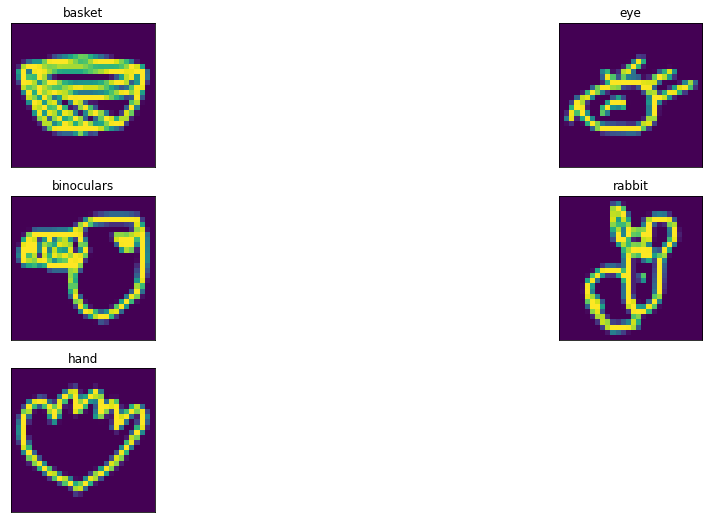

In [ ]:
## SHOWING SAMPLES ##

plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv(PATH_TO_ROOT + "train.csv",skiprows = [1], nrows=1)
    im = Image.open(PATH_TO_ROOT + 'images/'+classes[i]+'/'+ os.listdir(PATH_TO_ROOT + "images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    

# Up to you now

## Unsuccessful tries

### ResNet
Unsuccesful try with ResNet. We decided not to use it, or any other CNN, because we had trouble with upscaling images to 32x32, which is the minimum size for all those already existing neural networks.


In [ ]:
# DO NOT RUN !!!

## UNSUCCESSFUL TRY WITH RESNET ##

def newModel(input_shape,stop_freeze):
    # Uploading the model
    pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=[*input_shape,3], include_top=False)
  
    # Suppression of the classification layer
    pretrained_model.layers.pop()

    # Freezing all the layers, except the last stop_freeze
    for layer in pretrained_model.layers[:-stop_freeze]:
        layer.trainable = False

    # New classifier on top of the network
    model = tf.keras.Sequential([pretrained_model,
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(num_classes, activation='softmax')])
    return model
 

### Image extracting
Attempt at converting the images to matrices, using the open function and numpy arrays. It did not work for us because it took too long. However, we figured out later that the problem were the numpy arrays.

In [ ]:
# DO NOT RUN !!!

## UNSUCCESSFUL TRY TO OPEN IMAGES ##

index = 0
# Iterating all image path
for item in features_np:
    # Reading the image
    res = imageio.imread(features_np[index])
    # Open the image
    im = Image.open(item)
    # Appending it to the numpy array
    data = np.asarray(im)
    np.append(images_np, data)
    # Printing the index to have an idea of the performance
    print(index)
    index += 1

NameError: ignored

## Successful implementation

### Conversion of images to matrices of values
Since the append function was too slow with numpy arrays, we decided to employ a preinstalled python array, and to convert it to numpy after all the matrices had been appended to the array. In the end, in order to handle such matrices outside of the virtual machine, we chose to save them as .npy binary file, since it offered by far the best performances.

Procedure for the train dataset.

In [ ]:
## TRAIN DATA SET EXTRACTION ##

# Creating a list of the labels from the pandas dataframe
labels_np = np.array(train.loc[:,"class_label"])
# Doing the same thing for the relative path
features_np = np.array(PATH_TO_ROOT +  "images/" + train.loc[:,"relative_path"])
# Empty list to store matrices
images = []

In [ ]:
# Iterating all paths of the train dataset
for i in range(len(features_np)):
    # Reading the image from the file
    res = imageio.imread(features_np[index])
    # Loadding the image into a variable
    im = load_img(features_np[i])
    # Converting it to array 
    data = img_to_array(im)
    # Appending it to the images list
    images.append(data)
    print(i)

# Converting images to numpy
images_np = np.asarray(images)

# Displaying dimensions of the images for testing reasons, in order to see that the conversion worked
display((len(images_np)))
display(images_np[0].shape)

# Saving the numpy arrqay of matrices in a .npy binary file
np.save(PATH_TO_ROOT + "binary_test.npy", images_np)

Same procedure for the test dataset.

In [ ]:
## TEST DATA SET EXTRACTION ##

labels_np_test = np.array(test.loc[:,"class_label"])
features_np_test = np.array(PATH_TO_ROOT +  "images/" + test.loc[:,"relative_path"])
images_test = []

In [ ]:
# Iterating all paths of the test dataset
for i in range(len(features_np_test)):
    res = imageio.imread(features_np[index])
    im = load_img(features_np_test[i])
    data = img_to_array(im)
    images_test.append(data)
    print(i)

images_np_test = np.asarray(images_test)

display((len(images_np)))
display(images_np[0].shape)

# Saving the numpy array of matrices to another .npy binary file
np.save(PATH_TO_ROOT + "binary_test.npy", images_np_test)

### Loading saved matrices back to VM
Uploading the .npy file containing the array of matrices in the program

In [ ]:
## LOADING FROM .NPY FILE ##
# Loading the train and test dataset
out_train_X = np.load(PATH_TO_ROOT + "binary.npy")
out_test_X = np.load(PATH_TO_ROOT + "binary_test.npy")

## Train dataset ##
# Displaying the dimensions of an element to see if convertion from .npy file was done correctly
display((len(out_train_X)))
display(out_train_X.shape)
display(out_train_X[0].shape)

## Test dataset ##
# Displaying the dimensions of an element to see if convertion from .npy file was done correctly
display((len(out_test_X)))
display(out_test_X.shape)
display(out_test_X[0].shape)

75000

(75000, 28, 28, 3)

(28, 28, 3)

25000

(25000, 28, 28, 3)

(28, 28, 3)

### Data and label preparation
We then normalized the matrices both from test and train datasets, in order to have better results with the CNN. We tried to flatten them as well, but then we realised it did not make sense, since it must be done at the end of the CNN model.

We chose a three channels RGB format for the input, even though the images were originally black and white.

We normalized the values to range 0-1 by division by 255 because the pictures were RGB 256.

(75000, 28, 28, 3)
(28, 28, 3)


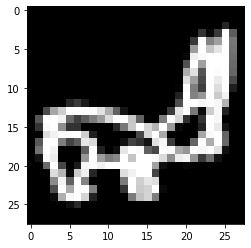

In [ ]:
## NORMALIZATION AND FLATTENING ##
train_X_norm = out_train_X / 255.0
test_X_norm = out_test_X / 255.0

##Attempt at flattening matrices
#arr_train = []
#for elem in out_train_X:
#    arr_train.append(elem.flatten()/255)

#arr_test = []
#for elem in out_test_X:
#    arr_test.append(elem.flatten()/255)

#train_X_norm = np.asarray(arr_train).astype('float32')
#test_X_norm = np.asarray(arr_test).astype('float32')

#testing that the flattening procedure was successful
print(train_X_norm.shape)
imageLike = train_X_norm[50000]
image = plt.imshow(imageLike)
print(imageLike.shape)

We used np_utils to cathegorize the labels from both train and test datsets, in order to be able to use them in the CNN

In [ ]:
## LABEL CATHEGORIZATION ##

y_train = np_utils.to_categorical(labels_np)
y_test = np_utils.to_categorical(labels_np_test)
num_classes = y_test.shape[1]
print(num_classes)

5


##Building our CNN

We took inspiration from the neural network described in the article:

https://www.datacareer.de/blog/quick-draw-classifying-drawings-with-python/, 

since it offered really high performances on a similar task, with 28x28 images. The model consists of several convolutional layers and max pooling layers, with one dropout layer. At the end we flattened the output of the neural network, thanks to a dense layer. For the model we always utilized the relu activation, but we used softmax at the end, as the task is about cathegorical classication. Our model used cathegorical cross entropy as loss function, and the Adam optimizer was the one which performed the best.



Eventually we tuned our hyperparamters, taking inspiration from the articles 

https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/#:~:text=The%20number%20of%20examples%20from,dynamics%20of%20the%20learning%20algorithm.&text=Batch%20size%20controls%20the%20accuracy,gradient%20when%20training%20neural%20networks

for the batch size, 

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

for the learning rate. 

After many trials with many different hyperparameters, we found that these settings are the ones that make the model perform the best. We started with a largr number of epochs, like 25, but it turned out that the model performed better at around 10 to 12 epochs. We also tried with larger and smaller learning rates, but we found this to be the optimal. Same goes for the batch size.

In [ ]:
## CNN MODEL BUILDING##

# Hyper parameters
lr = 0.001
num_epochs = 10
batch_size = 128

# We wanted to define the function makeModel(), because we need to call it again while loading the weights
def makeModel():
  # Create model
  model = Sequential()
  # Adding layers
  model.add(
      Conv2D(30, 
            (5, 5), 
            input_shape=(28, 28, 3), 
            activation='relu'))
  model.add(
      MaxPooling2D(
          (2, 2)))
  model.add(
      Conv2D(15, 
            (3, 3), 
            activation='relu'))
  model.add(
      MaxPooling2D(
          (2, 2)))
  model.add(
      Dropout(0.2))
  model.add(
      Flatten())
  model.add(
      Dense(128, 
            activation='relu'))
  model.add(
      Dense(50, 
            activation='relu'))
  model.add(
      Dense(num_classes, 
            activation='softmax'))
  # Choosig optimizer and loss function
  adam = Adam (learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  # See how the model looks like
  model.summary()
  return model

We wanted to see the shapes of the matrices one last time, just to be sure. Then we created a model calling the makeModel() function we defined previously

In [ ]:
## MODEL CREATION ##

print("Train")
print(train_X_norm.shape)
print(y_train.shape)
print("Test")
print(test_X_norm.shape)
print(y_test.shape)

# Define model
model = makeModel()

Train
(75000, 28, 28, 3)
(75000, 5)
Test
(25000, 28, 28, 3)
(25000, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 30)        2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 375)               0         
___________________________________________________

### Model fitting
We then fitted the model, testing all the different hyperparameters, to find out what was the best version of it. Then we evaluated it and printed the error

We train on our dataset and reached an accuracy of 95.1%

In [ ]:
## MODEL FIT ##

# Fit the model
model.fit(train_X_norm, y_train, validation_data=(test_X_norm, y_test), epochs=num_epochs, batch_size=batch_size)
# Final evaluation of the model
scores = model.evaluate(test_X_norm, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
586/586 [==============================] - 63s 105ms/step - loss: 0.4538 - accuracy: 0.8491 - val_loss: 0.2711 - val_accuracy: 0.9103
Epoch 2/10
586/586 [==============================] - 62s 106ms/step - loss: 0.2616 - accuracy: 0.9138 - val_loss: 0.2090 - val_accuracy: 0.9307
Epoch 3/10
586/586 [==============================] - 62s 106ms/step - loss: 0.2160 - accuracy: 0.9286 - val_loss: 0.1867 - val_accuracy: 0.9374
Epoch 4/10
586/586 [==============================] - 62s 106ms/step - loss: 0.1901 - accuracy: 0.9361 - val_loss: 0.1743 - val_accuracy: 0.9410
Epoch 5/10
586/586 [==============================] - 62s 106ms/step - loss: 0.1743 - accuracy: 0.9406 - val_loss: 0.1635 - val_accuracy: 0.9438
Epoch 6/10
586/586 [==============================] - 62s 106ms/step - loss: 0.1622 - accuracy: 0.9444 - val_loss: 0.1659 - val_accuracy: 0.9447
Epoch 7/10
586/586 [==============================] - 62s 106ms/step - loss: 0.1523 - accuracy: 0.9480 - val_loss: 0.1542 - val_ac

### Saving weights

We saved the weights. The name of the file containing the weights is defined by the accuracy of the model, so that it would be easier for us to recognize our best option

In [ ]:
## EVALUATION AND SAVING ##  
scores = model.evaluate(test_X_norm, y_test, verbose=1)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
print("Loss = {0:5.3f}, Accuracy = {1:5.3f}".format(scores[0], scores[1]))

name = ""
name = 'weights_v1_{acc}.h5'.format(acc = scores[1])
print(name)
model.save_weights(PATH_TO_ROOT + name)

782/782 [==============================] - 7s 9ms/step - loss: 0.1507 - accuracy: 0.9506
Large CNN Error: 4.94%
Loss = 0.151, Accuracy = 0.951
weights_v1_0.9505599737167358.h5


### Testing loaded model

To conclude with, we loaded the weights to have a final test and show how our model works in terms of prediction. For the prediction to work we had to feed the model an array of matrices, not just one picture: it needs four dimensions to work with.

The model requires a (-,28,28,3) dimension.

As a result of the prediction we received a matrice containing the probability of the model recognizing the pictures correctly. The higher the number the higher the probability of the model making the correct guess. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 30)        2280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

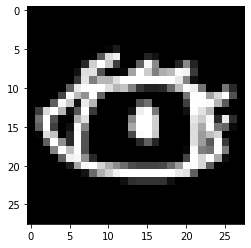

In [ ]:
## LOADING WEIGHTS ##
FILE_NAME = "weights_v1_0.9505599737167358.h5"
loaded_model = makeModel()
loaded_model.load_weights(PATH_TO_ROOT + FILE_NAME)

# Testing the sample
range = 23000
input = train_X_norm[range:range+1]
print(input.shape)

# Creating prediction
pred = loaded_model.predict(input)
res = np.argmax(pred)
print("Prediction: {a}".format(a = classes[res]))
plt.imshow(train_X_norm[range:range+1].reshape(28,28,3))